# k-Means Clustering on Satellite Images 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import exposure
import random
import sys

In [2]:
im1 = np.array(Image.open('band1.gif', 'r'))
im2 = np.array(Image.open('band2.gif', 'r'))
im3 = np.array(Image.open('band3.gif', 'r'))
im4 = np.array(Image.open('band4.gif', 'r'))

In [3]:
def euclidean_dist(x1,x2):
    dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5
    return dist


def clustering(k,imageInput,centroids):
    min_dist = sys.maxsize

    classData = np.zeros((512,512))

    for i in range(512):
        for j in range(512):
            for x in range(k):
                distance = euclidean_dist(imageInput[i,j,:],centroids[x])

                if(min_dist > distance):
                    min_dist = distance
                    label = x

            classData[i][j] = label
            min_dist = sys.maxsize
    
    return classData

def updateCentroids(imageInput,classData):
    sums =[0,0,0,0]
    total = 0
    updatedCentroids = np.zeros((k,4))

    for x in range (k):
        for i in range(512):
            for j in range(512):
                if classData[i][j] == x:
                    sums = np.array(sums) + imageInput[i,j,:]
                    total+=1
        sums = sums/total
        updatedCentroids[x] = sums
        sums = [0,0,0,0]
        total = 0
    return updatedCentroids

### 1. Initialize corresponding k color values for k clusters. 

In [4]:
 color = [[255,0,0],[0,255,0],[0,0,255],[0,255,255],[255,255,0]] 

In [5]:
# setting threshold
threshold = 20

In [6]:
k=2

### 2. Input satellite images, imageInput (512, 512,4). 


In [7]:
# 2. Input satellite images, imageInput (512, 512,4)

imageInput=np.array([im1,im2,im3,im4]).T


### 3. Initialize clusteredImage as the output image. 

In [8]:
clusteredImage = np.zeros((512,512,3))

### 4. Random coordinate

In [9]:
coord = np.array(([12,156],[230,83],[493,445],[75,478],[131,226]))

initCentroids = []
for i in range(k):
    initCentroids.append(imageInput[coord[i][0],coord[i][1],:])

initCentroids = np.array(initCentroids)
print(initCentroids.shape)

# we will be updating centroids later
centroids = initCentroids


(2, 4)


In [10]:
print(centroids)

[[12 11 11 24]
 [ 8  9 13 11]]


### 5. classData

In [11]:
### loop until stopping criteria is met
# at 11 matched
count = 0
while(count < threshold):
    classData = clustering(k,imageInput,centroids)
    updatedCentroids = np.round(updateCentroids(imageInput,classData))
    if (centroids==updatedCentroids).all():
        print("matched")
        break
    else:
        centroids = updatedCentroids
    count+=1
    

<ipython-input-3-d807f78819b7>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


matched


In [12]:
#np.set_printoptions(threshold=sys.maxsize)
#print(classData)

In [13]:
print(updatedCentroids)

[[ 9. 11. 14. 24.]
 [ 8.  9. 11. 15.]]


### 6. Setting Color

In [14]:
for i in range(512):
    for j in range(512):
        clusteredImage[i,j,:] = color[int(classData[i,j])]


### 7. Display Image

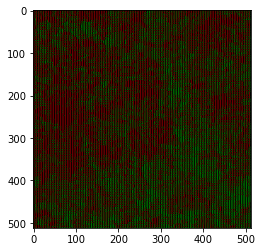

In [15]:
img = Image.fromarray(clusteredImage.astype(int), 'RGB')
imgplot = plt.imshow(img)
plt.show()

## Evaluation of clustering - silhouette coefficient 

In [16]:
def calSilhouette(p,classData,imageInput,k):
    
    total = 0
    distance = 0
    
    pixelValue = classData[p[0],p[1]]
    
    for i in range(512):
        for j in range(512):
            if classData[i][j] == pixelValue:
                distance += euclidean_dist(imageInput[i,j,:],imageInput[p[0],p[1],:])
                total+=1               
    a = distance/total
    
    # distances of other cluster
    
    d = []
    for x in range(k):
        if x == pixelValue:
            continue
        else:
            total = 0
            distance = 0
            for i in range(512):
                for j in range(512):
                    if classData[i][j] == x:
                        distance += euclidean_dist(imageInput[i,j,:],imageInput[p[0],p[1],:])
                        total+=1 
            
            if(total != 0):
                d.append(distance/total) 
            else:
                d.append(sys.maxsize)

    b = min(d)
    s = (b-a)/max(b,a)
    return s

### 1. Initialize silhouette array s (512,512). 

In [17]:
s = np.zeros((512,512))

### 2. For each pixel p in classData, sp = calSilhouette(p) 

In [18]:
# too heavy process, instead of 512 * 512, running it for 2 * 2
for i in range(2):
    for j in range(2):
        s[i][j] = calSilhouette([i,j],classData,imageInput,k)

<ipython-input-3-d807f78819b7>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


### 3. silhouette_coeff = max(s) 

In [19]:
silhouette_coeff_2 = np.amax(s) 
print(silhouette_coeff_2)

0.19820849508462704


## Repeating same process for k = 3,4,5

In [20]:
def kmeans(k,imageInput,coord,threshold):

    clusteredImage = np.zeros((512,512,3))
    initCentroids = []

    for i in range(k):
        initCentroids.append(imageInput[coord[i][0],coord[i][1],:])

    initCentroids = np.array(initCentroids)

    # we will be updating centroids later
    centroids = initCentroids

    # loop until stopping criteria is met
    count = 0
    while(count < threshold):
        classData = clustering(k,imageInput,centroids)
        updatedCentroids = np.round(updateCentroids(imageInput,classData))
        if (centroids==updatedCentroids).all():
            print("same centroids")
            break
        else:
            centroids = updatedCentroids
        count+=1

    # form image
    for i in range(512):
        for j in range(512):
            clusteredImage[i,j,:] = color[int(classData[i,j])]

    img = Image.fromarray(clusteredImage.astype(int), 'RGB')
    imgplot = plt.imshow(img)
    plt.show()


### k = 3

<ipython-input-3-d807f78819b7>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


same centroids


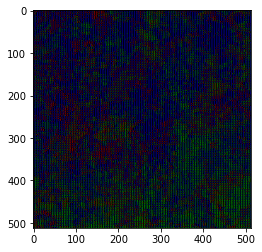

In [21]:
k = 3
kmeans(k,imageInput,coord,threshold)

In [22]:
# silloutte
s = np.zeros((512,512))
for i in range(2):
    for j in range(2):
        s[i][j] = calSilhouette([i,j],classData,imageInput,k)
silhouette_coeff_3 = np.amax(s) 


<ipython-input-3-d807f78819b7>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


### k = 4

<ipython-input-3-d807f78819b7>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


same centroids


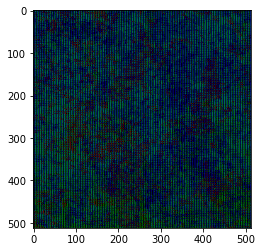

In [23]:
k = 4
kmeans(k,imageInput,coord,threshold)

In [24]:
# silloutte
s = np.zeros((512,512))
for i in range(2):
    for j in range(2):
        s[i][j] = calSilhouette([i,j],classData,imageInput,k)
silhouette_coeff_4 = np.amax(s) 

<ipython-input-3-d807f78819b7>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


### k = 5

<ipython-input-3-d807f78819b7>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


same centroids


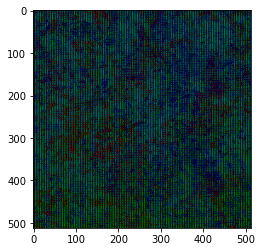

In [25]:
k = 5
kmeans(k,imageInput,coord,threshold)

In [26]:
# silhouette
s = np.zeros((512,512))
for i in range(2):
    for j in range(2):
        s[i][j] = calSilhouette([i,j],classData,imageInput,k)
silhouette_coeff_5 = np.amax(s) 

<ipython-input-3-d807f78819b7>:2: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


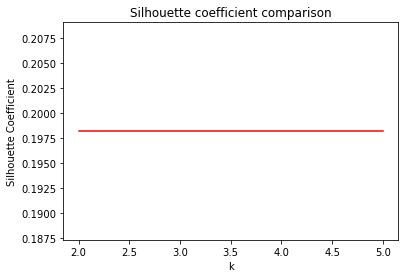

In [27]:
### Silhouette coefficient comparison
plt.plot([2,3,4,5], [silhouette_coeff_2,silhouette_coeff_3,silhouette_coeff_4, silhouette_coeff_5], color ="red")  
plt.title("Silhouette coefficient comparison")  
plt.xlabel("k")  
plt.ylabel("Silhouette Coefficient") 
plt.show()